In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# used to supress display of warnings
import warnings

from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

from surprise import Dataset,Reader
from surprise import SVD, KNNWithMeans
from surprise import accuracy

In [5]:
# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

In [9]:
# Reading Amazon electronics ratings data
df = pd.read_csv('C:/Users/Ovi/Desktop/499Project/dataset/ratings_Electronics (1).csv')
df.head()

AKM1MP6P0OYPR  0132793040       5.0  1365811200
0  A2CX7LUOHB2NDG  0321732944 5.0000000  1341100800
1  A2NWSAGRHCP8N5  0439886341 1.0000000  1367193600
2  A2WNBOD3WNDNKT  0439886341 3.0000000  1374451200
3  A1GI0U4ZRJA8WN  0439886341 1.0000000  1334707200
4  A1QGNMC6O1VW39  0511189877 5.0000000  1397433600

In [10]:
df.shape

(7824481, 4)

In [11]:
# Taking 10% of the dataset
e_df = df.iloc[:718110,0:]
e_df.shape

(718110, 4)

In [12]:
#datatypes
e_df.dtypes

AKM1MP6P0OYPR     object
0132793040        object
5.0              float64
1365811200         int64
dtype: object

In [13]:
e_df.rename(columns = {'AKM1MP6P0OYPR':'userId', '0132793040':'productId', '5.0':'ratings', 
                                 '1365811200':'timestamp',}, inplace = True)
e_df.head()

userId   productId   ratings   timestamp
0  A2CX7LUOHB2NDG  0321732944 5.0000000  1341100800
1  A2NWSAGRHCP8N5  0439886341 1.0000000  1367193600
2  A2WNBOD3WNDNKT  0439886341 3.0000000  1374451200
3  A1GI0U4ZRJA8WN  0439886341 1.0000000  1334707200
4  A1QGNMC6O1VW39  0511189877 5.0000000  1397433600

In [14]:
# Remove timestamp column
e_df.drop(['timestamp'], axis = 1, inplace = True)

In [15]:
# Check electronics ratings info
e_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718110 entries, 0 to 718109
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     718110 non-null  object 
 1   productId  718110 non-null  object 
 2   ratings    718110 non-null  float64
dtypes: float64(1), object(2)
memory usage: 16.4+ MB


In [16]:
# Get the top rows
e_df.head()

userId   productId   ratings
0  A2CX7LUOHB2NDG  0321732944 5.0000000
1  A2NWSAGRHCP8N5  0439886341 1.0000000
2  A2WNBOD3WNDNKT  0439886341 3.0000000
3  A1GI0U4ZRJA8WN  0439886341 1.0000000
4  A1QGNMC6O1VW39  0511189877 5.0000000

In [17]:
# Check Duplicates
e_df.duplicated().sum()

0

In [18]:
# Check the presence of missing values
e_df.isnull().sum()

userId       0
productId    0
ratings      0
dtype: int64

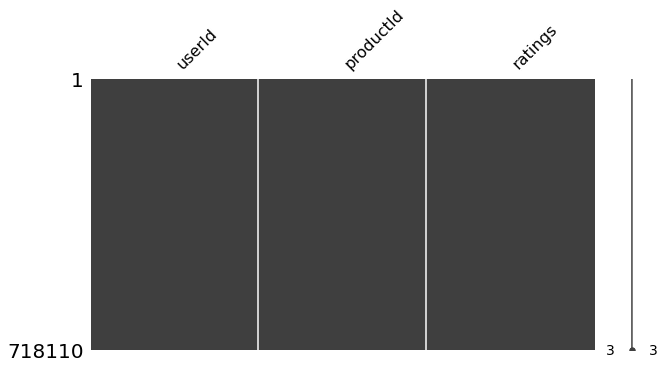

In [20]:
# Visualize missing values
import missingno as mno
mno.matrix(e_df, figsize = (10, 5));

In [21]:
# Check outliers 
np.where(e_df['ratings'] < 1)

(array([], dtype=int64),)

In [22]:
# Check outliers
e_df['ratings'].unique()

array([5., 1., 3., 2., 4.])

In [23]:
# Summary statistics of 'rating' variable
e_df.describe()

ratings
count 718110.0000000
mean       3.9777513
std        1.3974144
min        1.0000000
25%        3.0000000
50%        5.0000000
75%        5.0000000
max        5.0000000

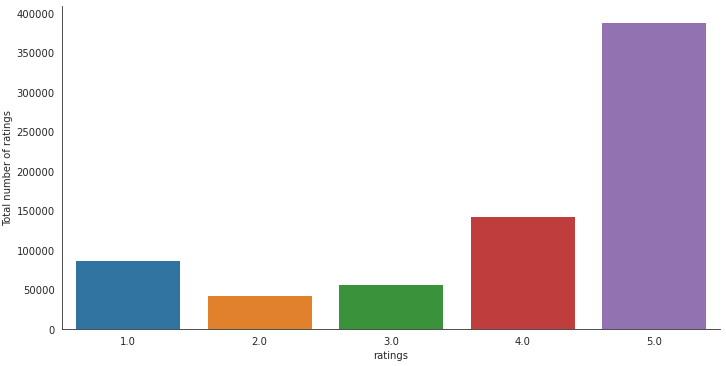

In [24]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=e_df, aspect=2.0, kind='count');
    g.set_ylabels("Total number of ratings") 

In [25]:
# Count users based on ratings
for i in range(1,6):
  print('Number of users who rated {0} ratings = {1}'.format(i, e_df[e_df['ratings'] == i].shape[0]))

Number of users who rated 1 ratings = 87304
Number of users who rated 2 ratings = 42806
Number of users who rated 3 ratings = 57074
Number of users who rated 4 ratings = 142305
Number of users who rated 5 ratings = 388621


In [26]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', e_df['userId'].nunique())
print('Number of unique PRODUCTS in Raw data = ', e_df['productId'].nunique())

Number of unique USERS in Raw data =  560470
Number of unique PRODUCTS in Raw data =  43618


In [27]:
# Top 10 users based on rating
most_rated_users = e_df.groupby('userId').size().sort_values(ascending=False)[:10]
most_rated_users

userId
A5JLAU2ARJ0BO     373
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    163
A6FIAB28IS79      107
AT6CZDCP4TRGA     107
AKT8TGIT6VVZ5     105
A11D1KHM7DVOQK    104
A2B7BUH8834Y6M     96
A2AEZQ3DGBBLPR     81
A2R6RA8FRBS608     75
dtype: int64

In [28]:
# Top 10 products based on rating
most_rated_products = e_df.groupby('productId').size().sort_values(ascending=False)[:10]
most_rated_products

productId
B0002L5R78    9487
B0001FTVEK    5345
B00007E7JU    3523
B000A6PPOK    2828
B00007M1TZ    2608
B00004ZCJE    2547
B000652M6Y    2152
B00020S7XK    2140
B0007MXZB2    2080
B00001P4ZH    2075
dtype: int64

In [29]:
users_count = e_df.userId.value_counts()
e_df_sample = e_df[e_df.userId.isin(users_count[users_count >= 50].index)]
print('Number of users who has given 50 or more number of ratings =', len(e_df_sample))

Number of users who has given 50 or more number of ratings = 2377


In [30]:
# Number of unique user id and product id in the sample dataset
print('Number of unique USERS in sample dataset = ', e_df_sample['userId'].nunique())
print('Number of unique PRODUCTS in sample dataset = ', e_df_sample['productId'].nunique())

Number of unique USERS in sample dataset =  25
Number of unique PRODUCTS in sample dataset =  2062


In [ ]:
#Calculate the density of the rating matrix=>


In [31]:
final_ratings_matrix = e_df_sample.pivot(index = 'userId', columns ='productId', values = 'ratings')
final_ratings_matrix.head()

productId       1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
userId                                                                       
A11D1KHM7DVOQK         NaN         NaN         NaN   2.0000000         NaN   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   

productId       B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
userId                                                                       
A11D1KHM7DVOQK         NaN         NaN         NaN         NaN   1.0000000   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   

productId       B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
userId                                                                       
A11D1KHM7DVOQK         NaN         NaN         NaN         NaN         NaN   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   

productId       B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
userId                                                                       
A11D1KHM7DVOQK         NaN         NaN         NaN         NaN         NaN   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   

productId       B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
userId                                                                       
A11D1KHM7DVOQK         NaN         NaN   4.0000000         NaN         NaN   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN   5.0000000         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   

productId       B00000JBUI  B00000JBYW  B00000JCTD  B00000JDGO  B00000JFDW  \
userId                                                                       
A11D1KHM7DVOQK         NaN   1.0000000   4.0000000         NaN         NaN   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN   5.0000000         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   

productId       B00000JFJA  B00000JFMK  B00000JFOF  B00000JHX1  B00000JLSJ  \
userId                                                                       
A11D1KHM7DVOQK         NaN         NaN         NaN         NaN         NaN   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   

productId       B00000JSGF  B00000JXV3  B00000K0KJ  B00000K1SF  B00000K3RI  \
userId                                                                       
A11D1KHM7DVOQK 

In [32]:
#final_ratings_matrix = final_ratings_matrix.fillna(final_ratings_matrix.mean(axis=0))
final_ratings_matrix = final_ratings_matrix.fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (25, 2062)
given_num_of_ratings =  2377
possible_num_of_ratings =  51550
density: 4.61%


In [33]:
# Matrix with one row per 'User' and one column per 'ProductId' for User-based CF
final_ratings_matrix.head()

productId       1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   2.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   1.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   4.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000JBUI  B00000JBYW  B00000JCTD  B00000JDGO  B00000JFDW  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   1.0000000   4.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000JFJA  B00000JFMK  B00000JFOF  B00000JHX1  B00000JLSJ  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000JSGF  B00000JXV3  B00000K0KJ  B00000K1SF  B00000K3RI  \
userId                                                                       
A11D1KHM7DVOQK 

In [34]:
# Matrix with one row per 'Product' and one column per 'User' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId      A11D1KHM7DVOQK  A12DLJESJKM1OQ  A149RNR5RH19YY  A1F9Z42CFF9IAY  \
productId                                                                    
1400532655       0.0000000       0.0000000       0.0000000       0.0000000   
B000000O48       0.0000000       0.0000000       0.0000000       0.0000000   
B000001OL6       0.0000000       0.0000000       0.0000000       0.0000000   
B000001OMN       2.0000000       0.0000000       0.0000000       0.0000000   
B00000J05A       0.0000000       0.0000000       0.0000000       0.0000000   

userId      A1FR68QH6Z4YZM  A1JWSDDIH5Z7DV  A1MJMYLRTZ76ZX  A1RPTVW5VEOSI  \
productId                                                                   
1400532655       0.0000000       0.0000000       0.0000000      0.0000000   
B000000O48       0.0000000       0.0000000       0.0000000      0.0000000   
B000001OL6       0.0000000       0.0000000       0.0000000      0.0000000   
B000001OMN       0.0000000       0.0000000       0.0000000      0.0000000   
B00000J05A       0.0000000       0.0000000       0.0000000      0.0000000   

userId      A203OCQQ12MAVT  A231WM2Z2JL0U3  A25HBO5V8S8SEA  A2AEZQ3DGBBLPR  \
productId                                                                    
1400532655       0.0000000       0.0000000       0.0000000       0.0000000   
B000000O48       0.0000000       0.0000000       0.0000000       5.0000000   
B000001OL6       0.0000000       0.0000000       0.0000000       0.0000000   
B000001OMN       0.0000000       0.0000000       0.0000000       0.0000000   
B00000J05A       0.0000000       0.0000000       0.0000000       0.0000000   

userId      A2B7BUH8834Y6M  A2BGZ52M908MJY  A2CL818RN52NWN  A2R6RA8FRBS608  \
productId                                                                    
1400532655       0.0000000       0.0000000       0.0000000       0.0000000   
B000000O48       0.0000000       0.0000000       0.0000000       0.0000000   
B000001OL6       0.0000000       0.0000000       0.0000000       4.0000000   
B000001OMN       0.0000000       0.0000000       0.0000000       0.0000000   
B00000J05A       0.0000000       0.0000000       0.0000000       0.0000000   

userId      A3OXHLG6DIBRW8  A5JLAU2ARJ0BO  A6FIAB28IS79  A7Y6AVS576M03  \
productId                                                                
1400532655       0.0000000      1.0000000     0.0000000      0.0000000   
B000000O48       0.0000000      0.0000000     0.0000000      0.0000000   
B000001OL6       0.0000000      0.0000000     0.0000000      0.0000000   
B000001OMN       0.0000000      0.0000000     0.0000000      0.0000000   
B00000J05A       0.0000000      0.0000000     3.0000000      0.0000000   

userId      ABH9D1TEOJ56E  AGHZXQL9F94T9  AKT8TGIT6VVZ5  AT2J7H5TRZM8Z  \
productId                                                                
1400532655      0.0000000      0.0000000      0.0000000      0.0000000   
B000000O48      0.0000000      0.0000000      0.0000000      0.0000000   
B000001OL6      0.0000000      0.0000000      0.0000000      0.0000000   
B000001OMN      0.0000000      0.0000000      0.0000000      0.0000000   
B00000J05A      0.0000000      0.0000000      0.0000000      0.0000000   

userId      AT6CZDCP4TRGA  
productId                  
1400532655      0.0000000  
B000000O48      0.0000000  
B000001OL6      0.0000000  
B000001OMN      0.0000000  
B00000J05A      0.0000000

In [ ]:
#Create Training and Test Set=>


In [35]:
# Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(e_df_sample, test_size = 0.3, random_state=123)
train_data.head()

userId   productId   ratings
447086   A5JLAU2ARJ0BO  B0002B80EA 4.0000000
175566  A25HBO5V8S8SEA  B00006B9QA 5.0000000
475836  A203OCQQ12MAVT  B0002J2O26 5.0000000
75323   A2B7BUH8834Y6M  B00004ZD36 4.0000000
467240  A203OCQQ12MAVT  B0002GV876 5.0000000

In [36]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (1663, 3)
Shape of testing data:  (714, 3)


In [ ]:
#Build Popularity Recommender model=>


In [37]:
# Count of userId for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'}, inplace=True)
train_data_grouped.head(10)

productId  score
0  1400532655      1
1  B000000O48      1
2  B000001OL6      1
3  B000001OMN      1
4  B00000J05A      1
5  B00000J0E8      1
6  B00000J1EP      1
7  B00000J1G6      1
8  B00000J1TX      1
9  B00000J1UQ      1

In [38]:
# Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
# Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
# Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head() 
popularity_recommendations 

productId  score      rank
85   B00004SB92      5 1.0000000
709  B00007KDVI      4 2.0000000
188  B00004Z5M1      3 3.0000000
213  B000050AQ7      3 4.0000000
248  B000056SSM      3 5.0000000

In [39]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [40]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

     userId   productId  score      rank
85       10  B00004SB92      5 1.0000000
709      10  B00007KDVI      4 2.0000000
188      10  B00004Z5M1      3 3.0000000
213      10  B000050AQ7      3 4.0000000
248      10  B000056SSM      3 5.0000000


The list of recommendations for the userId: 100

     userId   productId  score      rank
85      100  B00004SB92      5 1.0000000
709     100  B00007KDVI      4 2.0000000
188     100  B00004Z5M1      3 3.0000000
213     100  B000050AQ7      3 4.0000000
248     100  B000056SSM      3 5.0000000


The list of recommendations for the userId: 150

     userId   productId  score      rank
85      150  B00004SB92      5 1.0000000
709     150  B00007KDVI      4 2.0000000
188     150  B00004Z5M1      3 3.0000000
213     150  B000050AQ7      3 4.0000000
248     150  B000056SSM      3 5.0000000




In [ ]:
#User Based Collaborative Filtering model=>


In [41]:
# Matrix with one row per 'User' and one column per 'ProductId' for User-based CF
final_ratings_matrix.head()

productId       1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   2.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   1.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   4.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000JBUI  B00000JBYW  B00000JCTD  B00000JDGO  B00000JFDW  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   1.0000000   4.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000JFJA  B00000JFMK  B00000JFOF  B00000JHX1  B00000JLSJ  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000JSGF  B00000JXV3  B00000K0KJ  B00000K1SF  B00000K3RI  \
userId                                                                       
A11D1KHM7DVOQK 

In [42]:
# Define user index from 0 to 10
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0], 1)
final_ratings_matrix.head()

productId       1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   2.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   1.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   4.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000JBUI  B00000JBYW  B00000JCTD  B00000JDGO  B00000JFDW  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   1.0000000   4.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000JFJA  B00000JFMK  B00000JFOF  B00000JHX1  B00000JLSJ  \
userId                                                                       
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId       B00000JSGF  B00000JXV3  B00000K0KJ  B00000K1SF  B00000K3RI  \
userId                                                                       
A11D1KHM7DVOQK 

In [43]:
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

productId   1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   2.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   1.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
user_index                                                               
0            0.0000000   0.0000000   4.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000JBUI  B00000JBYW  B00000JCTD  B00000JDGO  B00000JFDW  \
user_index                                                               
0            0.0000000   1.0000000   4.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000JFJA  B00000JFMK  B00000JFOF  B00000JHX1  B00000JLSJ  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000JSGF  B00000JXV3  B00000K0KJ  B00000K1SF  B00000K3RI  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
1            0.0000000   4.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 

In [44]:
print(min(final_ratings_matrix.shape))

25


In [45]:
# Singular Value Decomposition
U, sigma, Vt = svds(final_ratings_matrix, k = 10)

In [46]:
print('Left singular vector matrix: \n',U)

Left singular vector matrix: 
 [[-8.28407595e-02  5.64722988e-02 -7.86153012e-02  1.33083855e-02
  -1.52731418e-02  3.15832686e-02 -7.44217107e-04 -1.65368284e-04
   3.75643662e-03  1.11253884e-02]
 [-4.85304949e-02 -6.85334983e-01 -3.48640646e-01  2.26709427e-02
  -4.73181665e-03  2.49262401e-02  3.94711231e-04  5.75176015e-03
  -1.59092871e-02  3.09322353e-02]
 [-2.12291163e-02 -1.04783518e-02 -4.79037322e-03  1.00988573e-02
  -3.73611560e-02  1.62813185e-02  2.41735357e-04 -2.48781820e-05
  -9.22774701e-03  7.58867959e-03]
 [ 7.59586113e-03 -5.61661503e-02 -8.25962519e-02 -6.65871989e-02
  -3.52824338e-02  8.04721304e-02 -1.74646366e-02 -2.88389591e-03
  -1.99327177e-02  1.77062427e-02]
 [ 2.54838060e-02 -2.35034304e-02 -3.13383374e-02  4.40729676e-03
   9.62815077e-03  9.05510519e-03 -1.62819658e-01 -1.61408203e-02
  -6.96158925e-03  2.36359935e-02]
 [-7.35816865e-04  3.74865179e-02 -8.90332322e-02 -9.72495754e-01
  -9.64788431e-02  9.99213569e-02 -3.50883251e-03  3.57542487e-03
  

In [47]:
print('Sigma: \n',sigma)

Sigma: 
 [38.36369291 38.90097322 39.38487605 39.80908849 43.77509973 44.38245196
 49.25697228 63.29210721 69.09320014 81.18120236]


In [48]:
# Construct a diagonal matrix in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[38.36369291  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         38.90097322  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         39.38487605  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         39.80908849  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         43.77509973  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         44.38245196
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  49.25697228  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         63.29210721  0.          0.        ]
 [ 0.          0.          0.        

In [49]:
print('Right singular vector matrix: \n',Vt)

Right singular vector matrix: 
 [[ 4.69265317e-04 -1.28736074e-01  3.12551098e-03 ...  3.15220709e-04
   3.32134422e-03  4.69265317e-04]
 [ 9.10533135e-04  8.75044161e-03  5.11335796e-02 ... -3.03207259e-03
  -3.02093090e-03  9.10533135e-04]
 [ 7.38279156e-04  7.06453277e-04 -6.89457391e-02 ...  1.29935548e-02
  -3.97847353e-03  7.38279156e-04]
 ...
 [-1.79924634e-04  7.92243885e-04  1.07370989e-04 ...  2.03401593e-04
  -1.27510531e-03 -1.79924634e-04]
 [ 3.79206296e-03 -2.41623524e-03 -3.53360043e-04 ... -4.97922242e-03
  -5.03782517e-04  3.79206296e-03]
 [ 1.18627037e-02  1.48919684e-03  3.53653626e-04 ...  1.55210448e-03
   1.45575533e-03  1.18627037e-02]]


In [50]:
all_users_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
ele_preds_ratings_df = pd.DataFrame(all_users_predicted_ratings, columns = final_ratings_matrix.columns)
ele_preds_ratings_df.head()

productId  1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
0           0.0096103   0.4253275   0.3376225   0.0355569   0.0306582   
1          -0.0099187   0.0030733  -0.4016086  -0.0116586   0.0110065   
2           0.0037200   0.1015922   0.0167024   0.0056246   0.1222508   
3           0.0064723  -0.0622636   0.1188734   0.0100442   0.1331115   
4           0.0169752  -0.1329720   0.0434794  -0.0008329  -0.0226616   

productId  B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
0          -0.0013571   0.0535881   0.0850655   0.3376225   0.0177784   
1           0.1067793  -0.1464523   0.0006147  -0.4016086  -0.0058293   
2           0.0004972   0.0340448   0.0203184   0.0167024   0.0028123   
3           0.0358177   0.0360865  -0.0124527   0.1188734   0.0050221   
4           0.0079469  -0.0019483  -0.0265944   0.0434794  -0.0004165   

productId  B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
0          -0.0138220   0.0510970  -0.0341694   0.0878870   0.0878870   
1          -0.0505894   0.0183441  -0.0870502  -0.1402016  -0.1402016   
2          -0.0027291   0.2037514   0.0370564  -0.0019500  -0.0019500   
3           0.0423641   0.2218526   0.0650023   0.2391942   0.2391942   
4           0.7880545  -0.0377693   0.0395873   0.1320086   0.1320086   

productId  B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
0           0.4253275   0.1670488   0.1701310   0.0306582   0.0122901   
1           0.0030733   0.6150075   0.0012293   0.0110065   0.3572882   
2           0.1015922   0.0188960   0.0406369   0.1222508   0.0125344   
3          -0.0622636   0.1817203  -0.0249054   0.1331115   0.0560325   
4          -0.1329720   0.0888280  -0.0531888  -0.0226616   0.0235636   

productId  B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
0           0.3376225  -0.0273355   0.0711137   0.0140616  -0.0002714   
1          -0.4016086  -0.0696401  -0.0233172   0.0553731   0.0213559   
2           0.0167024   0.0296451   0.0112493   0.0124457   0.0000994   
3           0.1188734   0.0520018   0.0200885   0.0154651   0.0071635   
4           0.0434794   0.0316699  -0.0016659  -0.0005387   0.0015894   

productId  B00000JBUI  B00000JBYW  B00000JCTD  B00000JDGO  B00000JFDW  \
0           0.1670488   0.0177784   0.0711137   0.0251106   0.0428705   
1           0.6150075  -0.0058293  -0.0233172   0.3421248  -0.1171618   
2           0.0188960   0.0028123   0.0112493   0.0154651   0.0272358   
3           0.1817203   0.0050221   0.0200885   0.1160655   0.0288692   
4           0.0888280  -0.0004165  -0.0016659   0.0382250  -0.0015586   

productId  B00000JFJA  B00000JFMK  B00000JFOF  B00000JHX1  B00000JLSJ  \
0          -0.0205016   0.3402620   0.0878870   0.0497155   0.0621443   
1          -0.0522301   0.0024587  -0.1402016   0.1126593   0.1408242   
2           0.0222339   0.0812737  -0.0019500   0.0110570   0.0138212   
3           0.0390014  -0.0498109   0.2391942   0.0466113   0.0582641   
4           0.0237524  -0.1063776   0.1320086   0.0150429   0.0188036   

productId  B00000JSGF  B00000JXV3  B00000K0KJ  B00000K1SF  B00000K3RI  \
0          -0.0273355  -0.0233172   0.0703096   0.0175774  -0.0008143   
1          -0.0696401   2.3839615  -0.1121613  -0.0280403   0.0640676   
2           0.0296451   0.0442985  -0.0015600  -0.0003900   0.0002983   
3           0.0520018   0.2736998   0.1913554   0.0478388   0.0214906   
4           0.0316699   0.1070465   0.1056069   0.0264017   0.0047681   

productId  B00000K3RO  B00000K4KH  B00000K4KU  B00001OPJ1  B00001OPK2  \
0          -0.0010857  -0.0341694   0.0878870   0.0112493   0.4253275   
1           0.0854234  -0.0870502  -0.1402016   0.0442985   0.0030733   
2           0.0003978   0.0370564  -0.0019500   0.0099566   0.1015922   
3           0.0286542   0.0650023   0.2391942   0.0123721  -0.0622636   
4           0.0063575   0.0395873   0.1320086  -0.0004309  -0.1329720   

productId  B00001OPK8  B00001OWYM  B00001P3XM  B0

In [51]:
# Recommend the items with the highest predicted ratings
def recommend_items(userId, final_ratings_matrix, ele_preds_ratings_df, num_recommendations):

    # Index starts at 0
    user_idx = userId-1
    
    # Get and sort the user's ratings
    sorted_user_ratings = final_ratings_matrix.iloc[user_idx].sort_values(ascending=False)

    # Sorted_user_ratings
    sorted_user_predictions = ele_preds_ratings_df.iloc[user_idx].sort_values(ascending=False)

    # Sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userId))
    print(temp.head(num_recommendations))

In [52]:
# Enter the 'userId' and 'num_recommendations' for the user 5
userId = 5
num_recommendations = 3
recommend_items(userId, final_ratings_matrix, ele_preds_ratings_df, num_recommendations)


Below are the recommended items for user(user_id = 5):

                   user_ratings  user_predictions
Recommended Items                                
B00009R6WO            0.0000000         0.9200631
B000021YU8            0.0000000         0.8990894
B00004XOM3            0.0000000         0.8936614


In [53]:
# Enter the 'userId' and 'num_recommendations' for the user 20
userId = 20
num_recommendations = 6
recommend_items(userId, final_ratings_matrix, ele_preds_ratings_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B00006IW1X            0.0000000         1.1390215
B00029U1DK            0.0000000         1.0749624
B00005LB8P            0.0000000         0.9113844
B0000632FZ            0.0000000         0.8943800
B00006JHTQ            0.0000000         0.8705326
B00006I5FQ            0.0000000         0.8466853


In [73]:
# Evaluate the Collaborative recommender model=>


In [54]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId   1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   2.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   1.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
user_index                                                               
0            0.0000000   0.0000000   4.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000JBUI  B00000JBYW  B00000JCTD  B00000JDGO  B00000JFDW  \
user_index                                                               
0            0.0000000   1.0000000   4.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000JFJA  B00000JFMK  B00000JFOF  B00000JHX1  B00000JLSJ  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
1            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
3            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
4            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

productId   B00000JSGF  B00000JXV3  B00000K0KJ  B00000K1SF  B00000K3RI  \
user_index                                                               
0            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
1            0.0000000   4.0000000   0.0000000   0.0000000   0.0000000   
2            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 

In [55]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
1400532655   0.0400000
B000000O48   0.2000000
B000001OL6   0.1600000
B000001OMN   0.0800000
B00000J05A   0.1200000
dtype: float64

In [56]:
# Predicted ratings 
ele_preds_ratings_df.head()

productId  1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
0           0.0096103   0.4253275   0.3376225   0.0355569   0.0306582   
1          -0.0099187   0.0030733  -0.4016086  -0.0116586   0.0110065   
2           0.0037200   0.1015922   0.0167024   0.0056246   0.1222508   
3           0.0064723  -0.0622636   0.1188734   0.0100442   0.1331115   
4           0.0169752  -0.1329720   0.0434794  -0.0008329  -0.0226616   

productId  B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
0          -0.0013571   0.0535881   0.0850655   0.3376225   0.0177784   
1           0.1067793  -0.1464523   0.0006147  -0.4016086  -0.0058293   
2           0.0004972   0.0340448   0.0203184   0.0167024   0.0028123   
3           0.0358177   0.0360865  -0.0124527   0.1188734   0.0050221   
4           0.0079469  -0.0019483  -0.0265944   0.0434794  -0.0004165   

productId  B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
0          -0.0138220   0.0510970  -0.0341694   0.0878870   0.0878870   
1          -0.0505894   0.0183441  -0.0870502  -0.1402016  -0.1402016   
2          -0.0027291   0.2037514   0.0370564  -0.0019500  -0.0019500   
3           0.0423641   0.2218526   0.0650023   0.2391942   0.2391942   
4           0.7880545  -0.0377693   0.0395873   0.1320086   0.1320086   

productId  B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
0           0.4253275   0.1670488   0.1701310   0.0306582   0.0122901   
1           0.0030733   0.6150075   0.0012293   0.0110065   0.3572882   
2           0.1015922   0.0188960   0.0406369   0.1222508   0.0125344   
3          -0.0622636   0.1817203  -0.0249054   0.1331115   0.0560325   
4          -0.1329720   0.0888280  -0.0531888  -0.0226616   0.0235636   

productId  B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
0           0.3376225  -0.0273355   0.0711137   0.0140616  -0.0002714   
1          -0.4016086  -0.0696401  -0.0233172   0.0553731   0.0213559   
2           0.0167024   0.0296451   0.0112493   0.0124457   0.0000994   
3           0.1188734   0.0520018   0.0200885   0.0154651   0.0071635   
4           0.0434794   0.0316699  -0.0016659  -0.0005387   0.0015894   

productId  B00000JBUI  B00000JBYW  B00000JCTD  B00000JDGO  B00000JFDW  \
0           0.1670488   0.0177784   0.0711137   0.0251106   0.0428705   
1           0.6150075  -0.0058293  -0.0233172   0.3421248  -0.1171618   
2           0.0188960   0.0028123   0.0112493   0.0154651   0.0272358   
3           0.1817203   0.0050221   0.0200885   0.1160655   0.0288692   
4           0.0888280  -0.0004165  -0.0016659   0.0382250  -0.0015586   

productId  B00000JFJA  B00000JFMK  B00000JFOF  B00000JHX1  B00000JLSJ  \
0          -0.0205016   0.3402620   0.0878870   0.0497155   0.0621443   
1          -0.0522301   0.0024587  -0.1402016   0.1126593   0.1408242   
2           0.0222339   0.0812737  -0.0019500   0.0110570   0.0138212   
3           0.0390014  -0.0498109   0.2391942   0.0466113   0.0582641   
4           0.0237524  -0.1063776   0.1320086   0.0150429   0.0188036   

productId  B00000JSGF  B00000JXV3  B00000K0KJ  B00000K1SF  B00000K3RI  \
0          -0.0273355  -0.0233172   0.0703096   0.0175774  -0.0008143   
1          -0.0696401   2.3839615  -0.1121613  -0.0280403   0.0640676   
2           0.0296451   0.0442985  -0.0015600  -0.0003900   0.0002983   
3           0.0520018   0.2736998   0.1913554   0.0478388   0.0214906   
4           0.0316699   0.1070465   0.1056069   0.0264017   0.0047681   

productId  B00000K3RO  B00000K4KH  B00000K4KU  B00001OPJ1  B00001OPK2  \
0          -0.0010857  -0.0341694   0.0878870   0.0112493   0.4253275   
1           0.0854234  -0.0870502  -0.1402016   0.0442985   0.0030733   
2           0.0003978   0.0370564  -0.0019500   0.0099566   0.1015922   
3           0.0286542   0.0650023   0.2391942   0.0123721  -0.0622636   
4           0.0063575   0.0395873   0.1320086  -0.0004309  -0.1329720   

productId  B00001OPK8  B00001OWYM  B00001P3XM  B0

In [57]:
# Average PREDICTED rating for each item
ele_preds_ratings_df.mean().head()

productId
1400532655   0.0418342
B000000O48   0.2122906
B000001OL6   0.2189889
B000001OMN   0.0248993
B00000J05A   0.1465682
dtype: float64

In [58]:
rmse_df = pd.concat([final_ratings_matrix.mean(), ele_preds_ratings_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(2062, 2)


Avg_actual_ratings  Avg_predicted_ratings  item_index
productId                                                        
1400532655           0.0400000              0.0418342           0
B000000O48           0.2000000              0.2122906           1
B000001OL6           0.1600000              0.2189889           2
B000001OMN           0.0800000              0.0248993           3
B00000J05A           0.1200000              0.1465682           4

In [59]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 10)
print('\nRMSE of SVD Model = {} \n'.format(RMSE))


RMSE of SVD Model = 0.0783045034 



In [60]:
# Enter the 'userId' and 'num_recommendations' for the user 5
userId = 5
num_recommendations = 5
recommend_items(userId, final_ratings_matrix, ele_preds_ratings_df, num_recommendations)


Below are the recommended items for user(user_id = 5):

                   user_ratings  user_predictions
Recommended Items                                
B00009R6WO            0.0000000         0.9200631
B000021YU8            0.0000000         0.8990894
B00004XOM3            0.0000000         0.8936614
B00005LENO            0.0000000         0.8729304
B0000TU7I6            0.0000000         0.8305732


In [68]:
# Enter the 'userId' and 'num_recommendations' for the user 20
userId = 25
num_recommendations = 5
recommend_items(userId, final_ratings_matrix, ele_preds_ratings_df, num_recommendations)


Below are the recommended items for user(user_id = 25):

                   user_ratings  user_predictions
Recommended Items                                
B00065DGNC            0.0000000         0.9005149
B00081A2KY            0.0000000         0.7644726
B0002375F8            0.0000000         0.6964514
B0009MZ9UA            0.0000000         0.6964514
B0000E1717            0.0000000         0.6615677


In [74]:
#  SVD Based Recommendation System using Surprise library=>


In [77]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(e_df_sample[['userId', 'productId', 'ratings']], reader)

In [78]:
# Split data into train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30, random_state=123)

In [79]:
# Fit the model on Training set
svd_model = SVD(n_factors=10, biased=False)
svd_model.fit(trainset)

In [80]:
# Evaluation of the model or Validate Training model on Test set

# Predict on Test set
svd_test_pred = svd_model.test(testset)

In [81]:
# Compute RMSE
accuracy.rmse(svd_test_pred)

RMSE: 1.6934


1.6934154833243438

In [82]:
#KNNWithMeans=>


In [83]:
# Fit the model on Training set
knn_model = KNNWithMeans(k=10, sim_options={'user_based': True})
knn_model.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [84]:
# Evaluation of the model or Validate Training model on Test set

# Predict on Test set
knn_test_pred = knn_model.test(testset)

# Compute RMSE
accuracy.rmse(knn_test_pred)

RMSE: 1.1904


1.1903669725717285

In [85]:
uid = "A11D1KHM7DVOQK"  # raw user id (as in the ratings file). They are **strings**!
iid = "B000001OMN"  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = knn_model.predict(uid, iid, r_ui=0.0, verbose=True)

user: A11D1KHM7DVOQK item: B000001OMN r_ui = 0.00   est = 4.16   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [86]:
#Generating top k recommendations=>


In [87]:
k=7
pred = pd.DataFrame(knn_test_pred)
pred[pred['uid'] == "A11D1KHM7DVOQK"][['iid', 'r_ui','est']].sort_values(by = 'r_ui', ascending = False).head(k)

iid      r_ui       est
71   B00005V54U 5.0000000 4.1593506
435  B0009E5YNA 5.0000000 4.1593506
107  B0002I5RHG 5.0000000 4.1593506
380  B0001F22PA 5.0000000 2.1861331
411  B00009XSXN 4.0000000 4.1593506
514  B0001IXUEE 4.0000000 4.1593506
466  B00005QBUU 4.0000000 4.1593506

In [88]:
pred.head()

uid         iid      r_ui       est  \
0   AT2J7H5TRZM8Z  B00006RSJ1 5.0000000 4.2444832   
1   AKT8TGIT6VVZ5  B0000520IV 5.0000000 4.1593506   
2  A1F9Z42CFF9IAY  B00009R6TA 5.0000000 3.5227273   
3  A1FR68QH6Z4YZM  B00020KPB2 5.0000000 5.0000000   
4  A2CL818RN52NWN  B00065WNW2 4.0000000 4.1593506   

                                             details  
0           {'actual_k': 1, 'was_impossible': False}  
1  {'was_impossible': True, 'reason': 'User and/o...  
2           {'actual_k': 0, 'was_impossible': False}  
3           {'actual_k': 1, 'was_impossible': False}  
4  {'was_impossible': True, 'reason': 'User and/o...

In [64]:
import pickle
pickle_out = open("ele_preds_ratings_df.pkl","wb")
pickle.dump(ele_preds_ratings_df, pickle_out)
pickle_out.close()

In [65]:
pickle_out = open("final_ratings_matrix.pkl","wb")
pickle.dump(final_ratings_matrix, pickle_out)
pickle_out.close()